In [1]:
import json

import pandas as pd

from math import pi
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.cluster import KMeans


In [2]:
def run_cluster(data, num_clusters=5):
    # create kmeans model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)

    # find centers and labels
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # DataFrame of centroids
    centroids_df = pd.DataFrame(centers, columns=data.columns).T

    # print items in clusters
    clusters = {}
    for i in range(len(labels)):
        clusters[players[i]] = labels[i]

    for i in range(len(centers)):
        out = [k for k,v in clusters.items() if v==i]

        print('-'*30)
        print(f'cluster index: {i}')
        for item in out:
            print(item)
        print('\n')

#     centroids_df.to_csv('final_clusters.csv')
    return clusters, centroids_df


In [3]:
data = pd.read_csv('Data/nba_data_player.csv')
players = data.player.to_list()


In [4]:
# nba_data = nba_data.set_index('rank')
nba_data = data.drop(['Unnamed: 0', 'player', 'pos', 'team_id', 'age', 'mp', 'fg', 'fga','fg3',
 'fg3a','fg2',
 'fg2a','ft',
 'fta','orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',], axis=1)


In [5]:
num_clusters = 8
clusters, centroids_df = run_cluster(nba_data,  num_clusters)


------------------------------
cluster index: 0
Steven Adams
LaMarcus Aldridge
Jarrett Allen
Deandre Ayton
Thomas Bryant
Clint Capela
Willie Cauley-Stein
John Collins
Anthony Davis
Andre Drummond
Joel Embiid
Derrick Favors
Rudy Gay
Taj Gibson
Rudy Gobert
Al Horford
Serge Ibaka
JaVale McGee
Paul Millsap
Jusuf Nurkic
Julius Randle
Pascal Siakam
Karl-Anthony Towns
Myles Turner
Nikola Vucevic
Hassan Whiteside
DeAndre Jordan


------------------------------
cluster index: 1
Alex Abrines
Jaylen Adams
Grayson Allen
Kadeem Allen
Justin Anderson
Carmelo Anthony
Dwayne Bacon
J.J. Barea
Keita Bates-Diop
Jerryd Bayless
Michael Beasley
Jaron Blossomgame
Isaiah Briscoe
Ryan Broekhoff
Dillon Brooks
MarShon Brooks
Lorenzo Brown
Deonte Burton
Bruno Caboclo
Jose Calderon
Jevon Carter
Alex Caruso
Omri Casspi
Gary Clark
Allen Crabbe
Luol Deng
Donte DiVincenzo
Jacob Evans
Dante Exum
Raymond Felton
Channing Frye
Markelle Fultz
Devonte' Graham
Treveon Graham
Daniel Hamilton
Isaiah Hartenstein
Solomon Hill
Da

In [6]:
player_df = data[['player', 'team_id']]

player_cluster_df = pd.DataFrame([clusters]).T.reset_index()
player_cluster_df = player_cluster_df.rename(columns={'index':'player', 0:'cluster'})

player_type_df = player_df.merge(player_cluster_df, on='player')
player_type_df


,player,team_id,cluster
0,Alex Abrines,OKC,1
1,Jaylen Adams,ATL,1
2,Steven Adams,OKC,0
3,Bam Adebayo,MIA,2
4,LaMarcus Aldridge,SAS,0
...,...,...,...
419,Garrett Temple,LAC,4
420,Jonas Valanciunas,MEM,3
421,Christian Wood,NOP,1
422,Delon Wright,MEM,2


In [10]:
player_type_df.to_csv('Data/presentation.csv')

In [7]:
headers = [f'cluster {x}' for x in range(8)]

teams_only_df = player_type_df.loc[player_type_df.team_id != 'TOT'].groupby(['team_id', 'cluster']).count()
max_cluster_size = max([max(teams_only_df.xs(i, level='cluster').player) for i in range(num_clusters)])


In [8]:
# number of players in each cluster
cluster_counts = player_type_df.groupby(['cluster'])['player'].count()

# calculate the number of players per cluster in the average team
avg_values = list(cluster_counts/30)
avg_values += avg_values[:1]

# list of angles for polar axis
angles = [n / float(num_clusters) * 2 * pi for n in range(num_clusters)]
angles += angles[:1]


with open('Data/team_colors.json', 'r') as f:
    team_colors = json.load(f)

def plot_radar(headers, input_values, title='test', fill_color='k', edge_color='k'):
    values = input_values.copy()
    values += values[:1]

    # add plot and figure properties
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, polar=True)
    ax.set_facecolor('#d3d3d3')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set tick parameters
    plt.xticks(angles[:-1], headers)
    plt.yticks([y for y in range(max_cluster_size+1)])
    ax.set_rlabel_position(0)

    ax.set_ylim([0, max_cluster_size])

    ax.tick_params(axis='x', pad=25)
    ax.tick_params(axis='y', colors='#000000', labelsize=14)

    # plot average team overlay
    ax.plot(angles, avg_values, color='#fcfcfc', linewidth=3.5)
    ax.fill(angles, avg_values, facecolor='#eeeeee', alpha=0.5)
    
    # plot and fill area
    ax.plot(angles, values, color=edge_color, linewidth=3.5)
    ax.fill(angles, values, facecolor=fill_color, alpha=0.5)

    ax.set_title(title, y=1)
    plt.show()


def plot_team(team_abbr):
    # filter data for team
    team_cluster_df = player_type_df.loc[player_type_df.team_id == team_abbr]

    # counts the number of players per cluster
    cluster_group = team_cluster_df.groupby(['cluster']).count()['player']
    cluster_count = {f'cluster {x}': 0 for x in range(8)}
    for i in range(len(cluster_group)):
        cluster_count[f'cluster {cluster_group.index[i]}'] = cluster_group.values[i]

    # get team colors
    colors = [item for item in team_colors[team_abbr.upper()].values()][1:]
    team = team_colors[team_abbr.upper()]['team']

    # plots radar chart
    plot_radar(headers, list(cluster_count.values()), f'player dist for {team}', colors[0], colors[1])


Dropdown(index=1, options=('ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND',…

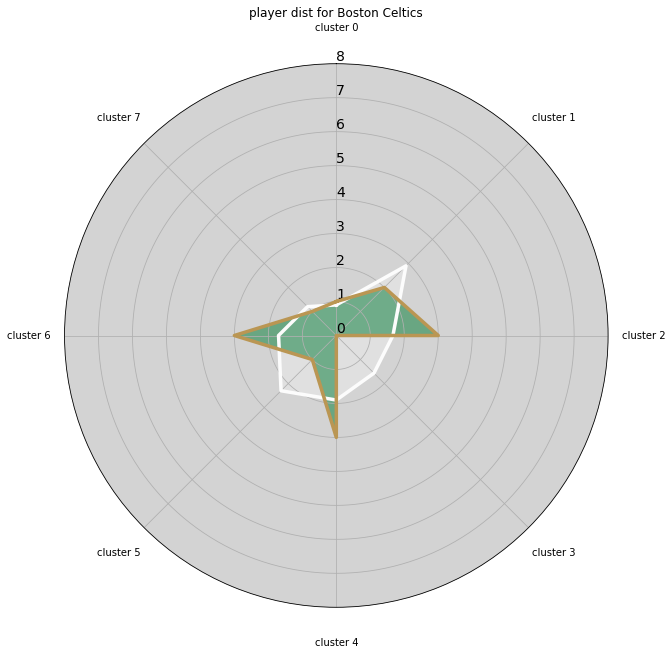

In [9]:
team_list = list(player_df.team_id.unique())
team_list.sort()

team_dropdown = widgets.Dropdown(
    options=team_list,
    value=team_list[0],
    disabled=False
)

display(team_dropdown)

def on_change(change):
    clear_output()
    display(team_dropdown)
    team_abbr = team_dropdown.value
    if change['name'] == 'value':
        plot_team(team_abbr)

team_dropdown.observe(on_change, type='change', names='value')
